<a href="https://colab.research.google.com/github/FlowAlpha/SPIRES_kenya_sensing/blob/main/1-dd-kenya_apache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Kenya project prediction notebook using an [Apache-Beam workflow](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/mai[…]ple-and-planet-ai/land-cover-classification/README.ipynb). And




https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV



---


To Do:


*   **FIX** misaligned tensor (under Train Model)
*   Check  `target` variable
*   Add block descriptions
*   Add descriptions



# Initial Software and Libraries

In [ ]:
#After running this cell, restart your kernel and run it again to properly import geemap
#import subprocess

# try:
#     import geemap
# except ImportError:
#     print('Installing geemap ...')
    
#     !pip install earthengine-api



## Install the proper modules and then **restarts runtime**


For standardization, we're pulling requirements directly from the git repo from [GoogleCloudPlatform](https://github.com/GoogleCloudPlatform)

In [ ]:
repo_url = "https://raw.githubusercontent.com/GoogleCloudPlatform/python-docs-samples/main/people-and-planet-ai/land-cover-classification"

!wget --quiet {repo_url}/requirements.txt

In [ ]:
!pip install --quiet --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00


In [ ]:
# Install the dependencies.
!pip install --quiet -r requirements.txt

# Restart the runtime by ending the process.
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ...

**RESTART RUNTIME** (Runtime<Restart)

In [ ]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)
# Folium setup.
import folium
print(folium.__version__)
import numpy as np

2.11.0
0.14.0


## Google Setup

Input your Google Cloud project id (might be different from name)

In [ ]:
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "ls-test-3-24" #@param {type:"string"}

# Quick input validations.
assert project, "ERROR: Make sure you are providing a valid Google Cloud project ID"

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [ ]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

### Cloud Storage Setup

You must have write access to a bucket to run this demo!  To run it read-only, use the demo bucket below, but note that writes to this bucket will not work.

In [ ]:
# INSERT YOUR BUCKET HERE:
bucket = 'dump_bucket_1'  #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

## Other Configurations

In [ ]:
# Defining neccessary functions

def mask_clouds_landsat(image: ee.Image) -> ee.Image:
  # Bits 3 and 5 are cloud shadow and cloud, respectively
  cloudShadowBitMask = (1 << 3) # 1000 in base 2
  cloudsBitMask = (1 << 5) # 100000 in base 2

  # Get the pixel QA band
  qa = image.select('pixel_qa')

  #Both flags should be set to zero, indicating clear conditions
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).bitwiseAnd(qa.bitwiseAnd(cloudsBitMask).eq(0))

  # Mask image with clouds and shadows
  return image.updateMask(mask)


def get_input_image(year: int, default_value: float = 1000.0) -> ee.Image:
  return(
      ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
      .filterDate(f'{year}-01-01', f'{year}-12-31')
      .map(mask_clouds_landsat)
      .select("B.*")
      .median()
      .unmask(default_value)
      .float()
  )


def cloudMaskL457(image): 
  qa = image.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
  # Remove edge pixels that don't occur in all bands
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)

In [ ]:
opticalBands = ['B3','B2','B1'] #RGB
thermalBands = ['B4','B3'] #NIR

# Specify inputs (Landsat bands) to the model and the response variable.

BANDS = ['R', 'G', 'B', 'NDVI']
RESPONSE = 'target'
FEATURES = BANDS + [RESPONSE] 

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 128
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

CENSUS_YR = '2009'  #@param {type:"string"}

In [ ]:
#Download Kenya Data and create Raster of villages
census_mask = ee.Image('projects/sanford-project-04a9/assets/Kenya/kenya_census_' + CENSUS_YR + '_rast').rename("target")

# #Get Kenya Feature collection
kenya = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Kenya')).set('ORIG_FID',0)

# Geometry selects from all of Kenya
image = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterDate(CENSUS_YR + '-01-01', CENSUS_YR + '-12-31')\
            .map(cloudMaskL457)\
            .median()\
            .clip(kenya.geometry().buffer(10000))\
            
image_ndvi = image.normalizedDifference(thermalBands).rename(['NDVI'])
image_rgb = image.select(opticalBands).rename(['R','G','B']) 
image = image_rgb.addBands(image_ndvi).unmask(0)


#Code to add in bands for propensity score prediction

#l7Unmasked = l7Masked.unmask(-9999)
#outside_circle = 'b("R") > -9000'
target = census_mask

In [ ]:
def get_label_image(image) -> ee.Image:
  #Download Kenya Data and create Raster of villages
  census_mask = ee.Image('projects/sanford-project-04a9/assets/Kenya/kenya_census_' + CENSUS_YR + '_rast')
  census_target = census_mask.rename("target")
  # #Get Kenya Feature collection
  kenya = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Kenya')).set('ORIG_FID',0)

  # Geometry selects from all of Kenya
  image = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterDate(CENSUS_YR + '-01-01', CENSUS_YR + '-12-31')\
              .map(cloudMaskL457)\
              .median()\
              .clip(kenya.geometry().buffer(10000))\
              
  image_ndvi = image.normalizedDifference(thermalBands).rename(['NDVI'])
  image_rgb = image.select(opticalBands).rename(['R','G','B']) 
  image = image_rgb.addBands(image_ndvi).unmask(0)


  #Code to add in bands for propensity score prediction

  #target = image.updateMask(census_target)
  #l7Unmasked = l7Masked.unmask(-9999)
  #outside_circle = 'b("R") > -9000'
  #target = l7Masked.rename("target")
  return census_target


In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

### View imagery
Census mask and LANDSAT7 

In [ ]:
# Census mask visualization
c_map = folium.Map(location=[0, 37], zoom_start = 6)

c_map.add_ee_layer(target, None, 'census mask map')
display(c_map)

In [ ]:
# Image mask visualization
mapid = image.getMapId({'bands': ['R', 'G', 'B'], 'min': 0, 'max': 3000})
map = folium.Map(location=[0, 37], zoom_start = 6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

# Training

## Sampling

Currently using stratified sampling in the Kenyan geometry

In [ ]:
from typing import Iterable

# seed: int, region = region: ee.Geometry, image = image: ee.Image, 
#    points_per_class = points_per_class: int, scale = scale: int
def sample_points(
    seed: int, region = None, image = None, points_per_class = None, scale = None
) -> Iterable[tuple[float, float]]:
    points = image.stratifiedSample(
        points_per_class,
        region=region,
        scale=scale,
        seed=seed,
        geometries=True,
    )
    for point in points.toList(points.size()).getInfo():
        yield point["geometry"]["coordinates"]

# Oversimplified North America region.
region = kenya.geometry()
labels_image = target
for point in sample_points(0, region, labels_image, points_per_class=2, scale=1000):
  print(point)

EEException: ignored

## Get training examples

In [ ]:
import io
import numpy as np
import requests
from google.api_core import exceptions, retry

@retry.Retry(deadline=10 * 60)  # seconds
def get_patch(image: ee.Image, lonlat: tuple[float, float], patch_size: int, scale: int) -> np.ndarray:
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL({
        "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
        "dimensions": [patch_size, patch_size],
        "format": "NPY",
    })

    # If we get "429: Too Many Requests" errors, it's safe to retry the request.
    # The Retry library only works with `google.api_core` exceptions.
    response = requests.get(url)
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text)

    # Still raise any other exceptions to make sure we got valid data.
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

Helper functions to get the inputs and labels patches of pixels. We'll use this function both for getting inputs for the training examples, and for predictions later on.

In [ ]:
from numpy.lib.recfunctions import structured_to_unstructured

def get_input_patch(image, year: int, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:
    patch = get_patch(image, lonlat, patch_size, scale=30)
    return structured_to_unstructured(patch)

def get_label_patch(image, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:

    patch = get_patch(image, lonlat, patch_size, scale=30)
    return structured_to_unstructured(patch)

In [ ]:
# Note: Changed get_input_patch(image, 2020, lonlat, patch_size) to be CENSUS_YR
def get_training_example(lonlat, image = None, labels = None, patch_size = 128):
    return (
        get_input_patch(image, CENSUS_YR, lonlat, patch_size),
        get_label_patch(labels, lonlat, patch_size),
    )

point = (40.86885385101763, 1.2531498213467325) # this point comes from sample_points[0] return
(inputs, labels) = get_training_example(point, image = image, labels = target, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")


inputs : float64 (128, 128, 4)
labels : uint8 (128, 128, 1)


In [ ]:
# Test that we have inputs (shouldn't be 0)
np.amax(inputs)

2505.5

Visualize

In [ ]:
# Grab visuals
inputs_visual = inputs[:,:, :3]
inputs_visual = inputs_visual/np.amax(inputs_visual)

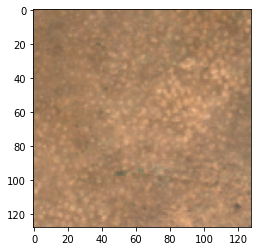

In [ ]:
import matplotlib.pyplot as plt

# Show visuals
plt.imshow(inputs_visual)
plt.show()

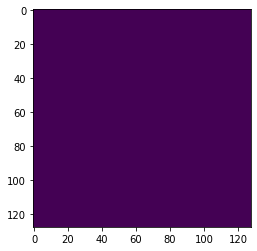

In [ ]:
# Currently 0
np.amax(labels)
plt.imshow(labels)
plt.show()

In [ ]:
# Showing correct(?) output
import folium

mapid = target.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[0, 37], zoom_start = 6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
#Showing correct output

import folium

vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["R", "G", "B"],
}
folium.Map(
    location=(0,37),
    zoom_start=6,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## Apache-beam

Serialize to TFRecords

In [ ]:
import tensorflow as tf

def serialize(inputs: np.ndarray, labels: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(data).numpy()])
        )
        for name, data in {"inputs": inputs, "labels": labels}.items()
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

serialized = serialize(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 540768 bytes


### Creating Dataset


In [ ]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
%cd python-docs-samples/people-and-planet-ai/land-cover-classification

fatal: destination path 'python-docs-samples' already exists and is not an empty directory.
/content/python-docs-samples/people-and-planet-ai/land-cover-classification


In [ ]:
from create_dataset import serialize_tensorflow
inputs = inputs_visual
serialized = serialize_tensorflow(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 409696 bytes


### Pipeline info


```
with beam.Pipeline() as pipeline:
    (...
```


[Example1 Notebook](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=-HB0AdqOr06y)

[Example2 Notebook](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/mai[%E2%80%A6]ple-and-planet-ai/land-cover-classification/README.ipynb) 

Useful links:

* [Beam Quickstart](https://beam.apache.org/get-started/quickstart/python/)

* [Beam Guide](https://beam.apache.org/documentation/programming-guide/)

* [Pipeline Options](https://beam.apache.org/documentation/programming-guide/#configuring-pipeline-options)




In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
# note to self: sample_points in the example takes 
#def sample_points(seed: int, polygons: list[list[tuple[float, float]]], 
#points_per_class: int, scale: int=1000) ->Iterable[tuple[float, float]]

class CustomFn(beam.CombineFn):
    def create_accumulator(self):
        sum = 0.0
        count = 0
        accumulator = sum, count
        return accumulator

    def add_input(self, accumulator, input):
        sum, count = accumulator
        return sum + len(input), count + 1

    def merge_accumulators(self, accumulators):
        sums, counts = zip(*accumulators)
        return sum(sums), sum(counts)
     
    # [END COPIED CODE] - MODIFIED LINES:
    def extract_output(self, accumulator, MODE='AVERAGE'):
        sum, count = accumulator
        if count == 0:
            return float('NaN')

        if MODE == 'SUM':
            return int(sum)
        elif MODE == 'COUNT':
            return int(count)
        elif MODE == 'INT_AVERAGE':
            return int(sum / count)
        else:
            return sum / count


def prepare_key_value_pairs(element):
    key_value_tuple = ( (element['key_column_1'], 
          element['key_column_...'],  
          element['key_column_n'] 
          ), 
          element['value_column_1'] )
    return key_value_tuple

def transform_data(data):
    data_out = (
            data
            | 'Step 1' >> beam.Map(prepare_key_value_pairs)
            | 'Step 2' >> beam.GroupByKey()
            
            # This line fails with DataflowRunner, but not with DirectRunner (locally):
            # | 'Old Step 3' >> beam.CombineValues(beam.combiners.CountCombineFn())

            # This works with DataflowRunner: CombinePerKey instead of CombineValues
            # https://beam.apache.org/documentation/transforms/python/aggregation/combineperkey/#example-5-combining-with-a-combinefn
            | 'New Step 3 New' >> beam.CombinePerKey(CustomFn())
    )
    return data_out


with beam.Pipeline() as pipeline:
    (
        pipeline
        | "🌱 Make seeds" >> beam.Create([0])
        | "🛰 Sample points" >> beam.FlatMap(sample_points, region = region, image = labels_image, points_per_class = 2, scale = 1000)
        | "📖 Get examples" >> beam.Map(get_training_example, image = image, labels = target, patch_size = 128)
        | "✍🏽 Serialize" >> beam.MapTuple(serialize_tensorflow)
        | "📚 Write TFRecords" >> beam.io.WriteToTFRecord(
            "data/part", file_name_suffix=".tfrecord.gz"
        )
    )

In [ ]:
# Let's take a look at the dataset files.
!ls -lh data

total 668K
-rw-r--r-- 1 root root 666K Mar 16 12:44 part-00000-of-00001.tfrecord.gz


Next use a distributed runner to run on a larger dataset

In [ ]:
points_per_class = 100

!python create_dataset.py "tensorflow" \
  --data-path="gs://{bucket}/land-cover/data" \
  --points-per-class="{points_per_class}" \
  --runner="DataflowRunner" \
  --project="{project}" \
  --region="{location}" \
  --temp_location="gs://{bucket}/land-cover/temp"

INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[list[tuple[float, float]]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "Iterable[tuple[float, float]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[list[tuple[float, float]]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to An

In [ ]:
print(target.getInfo())

{'type': 'Image', 'bands': [{'id': 'target', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [29676, 37426], 'crs': 'EPSG:32737', 'crs_transform': [30, 0, -67088.3816999998, 0, -30, 10605534.1865]}], 'version': 1667329384912485, 'id': 'projects/sanford-project-04a9/assets/Kenya/kenya_census_2009_rast', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[33.899676480467825, -3.712381049241454], [33.89351506051154, -4.661100260662413], [37.900507946594495, -4.678851591182628], [41.91295489440698, -4.673655155923738], [41.90670508116313, -2.7713382186237463], [41.90334965079649, -0.23517632895609153], [41.90379440308304, 1.032915523138402], [41.90893442251192, 3.5690508582490628], [41.916536101341734, 5.471324856577909], [37.899154212658445, 5.477412980838261], [33.88725958188004, 5.456615444350572], [33.902203461985884, 3.2433133930818694], [33.90731169057764, 1.978657066626101], [33.910330837555634, 0.08162750001535511], [33.9092551841757, 

In [ ]:
target.bandNames().getInfo()

['target']

In [ ]:
target = get_label_image(image)
#Visualize imagery
map_target = folium.Map(location=[0, 37], zoom_start = 6)
map_target.add_ee_layer(target, None, 'target')

display(map_target)

# Train Model

In [ ]:
# Specify names locations for outputs in Cloud Storage. 
FOLDER = 'unet_11-17_128_tiles_kenya_r_g_b_ndvi_treatment'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

In [ ]:
!pwd

!cd ~
!cd data
!ls

/content/python-docs-samples/people-and-planet-ai/land-cover-classification
cloud-tensorflow.ipynb	 noxfile_config.py	requirements-test.txt
create_dataset.py	 predict_batch.py	requirements.txt
data			 predict-locations.csv	serving
e2e_test.py		 pretrained-model	setup.py
images			 __pycache__		trainer
land-cover-change.ipynb  README.ipynb		visualize.py
MANIFEST.in		 README.md


**Issue**

Running into error:

```
InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Type mismatch between parsed tensor (float) and dtype (uint8)
	 [[{{node ParseTensor_1}}]] [Op:IteratorGetNext]
```

Notably,


```
Type mismatch between parsed tensor (float) and dtype (uint8)
```





In [ ]:
from trainer.tf_model import read_dataset

data_path = f"data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

InvalidArgumentError: ignored

In [ ]:
import tensorflow as tf
from trainer.tf_model import create_model, split_dataset

# (train_dataset, test_dataset) = split_dataset(dataset)
model = create_model(dataset)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)